## Personalized recommendation system using random walk based markov model

In [48]:
import numpy as np
import pandas as pd
import os
import collections
import itertools
import random

import matplotlib
import matplotlib.pyplot as plt
import time

In [31]:
## related functions
def filter_split_data(data, n_freq):
    # filter less frequent users to reduce sparsity
    uids = data['UserId']
    user_freq = collections.Counter(uids)
    # filter users 
    counter_df = pd.DataFrame.from_dict(user_freq, orient='index').reset_index()
    counter_df = counter_df.rename(columns={'index':'usd', 0:'count'})
    user_sel = counter_df[counter_df['count']>8]['usd']
    
    data_filtered = data[data['UserId'].isin(user_sel)]
    data_filtered = data_filtered.reset_index()
    
    # split data into train and validation
    val_index = list()
    train_index = list()
    for i in user_sel:
        index = data_filtered[data_filtered['UserId'] == i].index.tolist()
        val_index_user = random.sample(index, 3)
        val_index = list(itertools.chain(val_index, val_index_user))
        #val_index = list(itertools.chain(val_index, index[-3:]))
        
        #train_index = list(itertools.chain(train_index, index[0:len(index)-3]))
        train_index = list(itertools.chain(train_index, list(set(index) - set(val_index_user))))
        
    train_data = data_filtered.loc[train_index]
    val_data = data_filtered.loc[val_index]
    
    # reset index
    train_data = train_data.reset_index()
    val_data = val_data.reset_index()
    return train_data, val_data

## calculate transition probability matrix from datasets
def transition_prob(data):
    items = data['ItemId'].unique()
    uids = data['UserId'].unique()
    # initialization of transition probability matrix
    t = np.zeros((len(items), len(items)))
    
    for j in range(len(uids)):
        uid_df = data[data["UserId"] == uids[j]]
        k=0
        while(k>=0 and k<uid_df.shape[0]-1):
            row_item = uid_df.iloc[k, :]['ItemId']
            row_index = np.where(items == row_item)
            next_item = uid_df.iloc[k+1, :]['ItemId']
            col_index = np.where(items == next_item)
            t[row_index, col_index] = t[row_index, col_index] + 1
            k = k+1
    
    #print(t)
    t = t/t.sum(axis=1)[:,None]
    t = np.nan_to_num(t)
    return t

## generate user behavior matrix
def user_spec_vec(data):
    items = data['ItemId'].unique()
    uids = data['UserId'].unique()
    
    # initiate user specific matrix
    u = np.zeros((len(uids), len(items)))
    
    for i in range(len(uids)):
        uid_df = data[data["UserId"] == uids[i]]
        for j in range(len(items)):
            item_index = uid_df[uid_df['ItemId'] == items[j]]['ItemId']
            if len(item_index) > 0:
                col_index = np.where(items == items[j])
                u[i, col_index] = len(item_index)
    
    norm_u = u/u.sum(axis=1)[:,None]
    norm_u = np.nan_to_num(norm_u)
    return u, norm_u

## calculate user-specific recomendation matrix
def walk_alg(u, T, alpha, steps=100):
    # initialize recomendation matrix
    p = u  # dim: u*n
    
    for k in range(steps):
            p =  alpha*np.dot(p, T) + (1-alpha)*u
            # norm p
            p_updated = p/p.sum(axis=1)[:,None]
            #if sum(p.sum(axis=1) - p_updated(axis=1)) < ttol:
            #    return(p)
            
            p = p_updated
            
    return p

## get ntop recommendations list for each user
def user_recommendation(p, items, usid, ntop=3):
    recomm_list = list()
    sort = np.argsort(-p, axis=1)
    
    for i in range(p.shape[0]):
        recomm_list.append(list(items[sort[i, range(ntop)]]))
    
    df = pd.DataFrame(recomm_list)
    df['usid'] = usid
    return df


def performance(recomm, val):
    usid = recomm['usid'].unique()
    val = val[val['UserId'].isin(usid)]
    
    overlap = 0
    for i in range(len(usid)):
        user = usid[i]
        val_user = val[val['UserId'] == user]
        #recomm_user = recomm[recomm['UserId'] == user]
        recomm_list = set(recomm[recomm['usid'] == user].iloc[0, 0:3].tolist())
        val_list = set(val_user['ItemId'])
        intersection = recomm_list & val_list
        overlap = overlap + len(intersection)/len(recomm_list)
    return(np.round(overlap/len(usid), 2))

In [3]:
## read datasets
data = pd.read_csv("datasets/events_train_full.0.txt", sep="\t")
data.head()

n_freq = 8
# filter less frequent users to reduce sparsity
train_data, val_data = filter_split_data(data, n_freq)

## get subset data
data_sel = train_data[0:5000]

# item and user lists
items = data_sel['ItemId'].unique()
uids = data_sel['UserId'].unique()

# generate transition prob matrix
### test for the first 1000 rows
T = transition_prob(data_sel)
u, u_norm = user_spec_vec(data_sel)

C:\Users\Qiwen.000\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide


In [34]:
T

array([[0.75, 0.25, 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.75]])

In [35]:
u_norm

array([[0.66666667, 0.16666667, 0.16666667, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00471698, 0.00471698,
        0.02358491]])

In [25]:
# generate recommendation matrix
p = walk_alg(u_norm, T, alpha=1, steps=50)
p

C:\Users\Qiwen.000\Anaconda3\lib\site-packages\ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in true_divide


array([[5.62500000e-01, 1.87500000e-01, 2.50000000e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.67556739e-04, 1.67556739e-04, 1.53394824e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        7.58545925e-05, 7.58545925e-05, 4.86652847e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.94773375e-03, 1.94773375e-03, 3.72140934e-02]])

In [28]:
user_recommendation(p, items, uids, ntop=6)

,0,1,2,3,4,5,usid
0,407485,354233,133814,390395,358895,178498,1230
1,381314,175292,407485,390395,358895,178498,1722
2,29863,335661,252596,426277,42002,382054,1879
3,257575,6163,309819,358819,239164,101722,2114
4,239164,101722,358819,346661,314912,217429,2270
...,...,...,...,...,...,...,...
193,291485,137352,296619,369565,66548,179834,77109
194,20351,198784,10516,119736,125751,314912,77177
195,137352,296619,164027,188169,165161,369565,77212
196,69689,377286,281276,326861,20351,369447,77371


In [37]:
## evaluate performance based on validation set
### measured by overlap between recommended items and items in the validation set
recomm = user_recommendation(p, items, uids, ntop=3)

## parameter comparison
### vary steps and datasets
perf = list()
steps = np.linspace(10, 100, 10).astype(int)
sizes = np.linspace(100, 1000, 10).astype(int)

for i in range(len(sizes)):
    ## get subset data
    data_sel = train_data[0:sizes[i]]
    
    # item and user lists
    items = data_sel['ItemId'].unique()
    uids = data_sel['UserId'].unique()
    
    # generate transition prob matrix
    ### test for the first 1000 rows
    T = transition_prob(data_sel)
    u, u_norm = user_spec_vec(data_sel)
    
    step = 10
    p = walk_alg(u_norm, T, alpha=0, steps=step)
    recomm = user_recommendation(p, items, uids, ntop=6)
    perf.append(performance(recomm, val_data))

C:\Users\Qiwen.000\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Qiwen.000\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Qiwen.000\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Qiwen.000\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Qiwen.000\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Qiwen.000\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Qiwen.000\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Qiwen.000\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: i

Text(0.5, 0, 'training sizes')

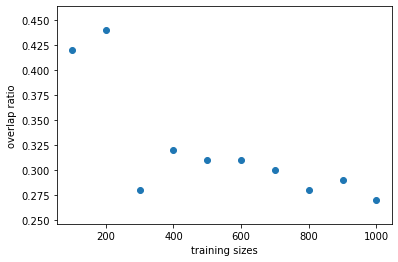

In [49]:
plt.scatter(sizes, perf)
plt.ylabel("overlap ratio")
plt.xlabel("training sizes")

In [60]:
# running time
recomm = user_recommendation(p, items, uids, ntop=3)

## parameter comparison
### vary steps and datasets
t = list()
#steps = np.linspace(10, 100, 10).astype(int)
sizes = np.linspace(100, 5000, 10).astype(int)

for i in range(len(sizes)):
    ## get subset data
    start_time = time.time()
    data_sel = train_data[0:sizes[i]]
    
    # item and user lists
    items = data_sel['ItemId'].unique()
    uids = data_sel['UserId'].unique()
    
    # generate transition prob matrix
    ### test for the first 1000 rows
    T = transition_prob(data_sel)
    u, u_norm = user_spec_vec(data_sel)
    
    step = 10
    p = walk_alg(u_norm, T, alpha=0, steps=step)
    recomm = user_recommendation(p, items, uids, ntop=6)
    time_passed = time.time() - start_time
    
    t.append(time_passed)


C:\Users\Qiwen.000\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Qiwen.000\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Qiwen.000\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Qiwen.000\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Qiwen.000\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Qiwen.000\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Qiwen.000\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Qiwen.000\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: i

Text(0.5, 0, 'data sizes')

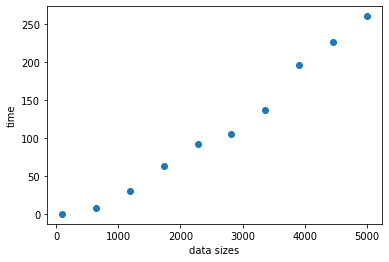

In [61]:
## plotting
plt.scatter(sizes, t)
plt.ylabel("time")
plt.xlabel("data sizes")

In [65]:
perf = list()
steps = np.linspace(10, 3000, 100).astype(int)
#sizes = np.linspace(100, 1000, 10).astype(int)

for i in range(len(steps)):
    ## get subset data
    #data_sel = train_data[0:sizes[i]]
    train_data, val_data = filter_split_data(data, 8)
    data_sel = train_data[0:500]
     
    # item and user lists
    items = data_sel['ItemId'].unique()
    uids = data_sel['UserId'].unique()
    
    # generate transition prob matrix
    ### test for the first 1000 rows
    T = transition_prob(data_sel)
    u, u_norm = user_spec_vec(data_sel)
    
    step = steps[i]
    p = walk_alg(u_norm, T, alpha=0, steps=step)
    recomm = user_recommendation(p, items, uids, ntop=6)
    perf.append(performance(recomm, val_data))

C:\Users\Qiwen.000\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Qiwen.000\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Qiwen.000\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Qiwen.000\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Qiwen.000\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Qiwen.000\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Qiwen.000\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Qiwen.000\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: i

C:\Users\Qiwen.000\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Qiwen.000\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Qiwen.000\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Qiwen.000\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Qiwen.000\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Qiwen.000\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Qiwen.000\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Qiwen.000\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: i

Text(0.5, 1.0, 'Model performance change on small dataset')

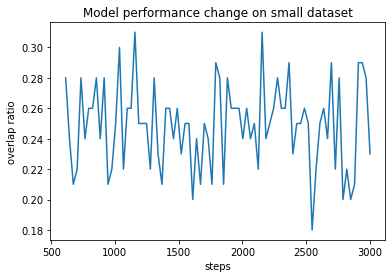

In [73]:
plt.plot(steps[20:100], perf[20:100])
plt.ylabel("overlap ratio")
plt.xlabel("steps")
plt.title("Model performance change on small dataset")

In [76]:
val_data

,level_0,index,Time,UserId,ItemId,SessionId
0,5,103,1431145641,1230,133814,1518
1,1,99,1431145564,1230,407485,1518
2,6,104,1431146331,1230,123636,1518
3,53,180,1432574839,1722,175292,2131
4,31,158,1431552662,1722,381314,2109
...,...,...,...,...,...,...
11008,76635,213576,1432658476,1406881,237561,1760225
11009,76640,213581,1432658707,1406881,29677,1760225
11010,76652,213645,1431642030,1407397,111530,1760885
11011,76651,213644,1431641928,1407397,111530,1760885
